In [1]:
import os
import glob
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from osgeo import gdal
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
years = [2010, 2011, 2012]
xbounds = slice(-115, -105)
ybounds = slice(56, 50)

In [3]:
# Get 2020 filenames
ndvi_filenames_all = sorted(glob.glob("files/*.hdf"))
era5_filenames_all = sorted(glob.glob("era5_data/*"))

ndvi_filenames, era5_filenames = [], []
for year in years:
    ndvi_filenames.extend([file for file in ndvi_filenames_all if f"A{year}" in file])
    era5_filenames.extend([file for file in era5_filenames_all if str(year) in file])

len(ndvi_filenames), len(era5_filenames)

(69, 6)

In [4]:
%%time
ndvi_dss = []
# Load all 2020 files
for filename in ndvi_filenames:
    ndvi_ds = rxr.open_rasterio(filename)
    # Add time dimension, with time as beginning date
    ndvi_ds = ndvi_ds.isel(band=0).expand_dims("time")
    ndvi_ds["time"] = [
        datetime.strptime(ndvi_ds.attrs["RANGEBEGINNINGDATE"], "%Y-%m-%d")
    ]
    # Reproject to EPSG:4326
    ndvi_ds = ndvi_ds.rio.reproject("EPSG:4326")
    # Select NDVI variable & slice data by bounds
    ndvi_ds = ndvi_ds[["250m 16 days NDVI"]].sel(x=xbounds, y=ybounds)
    ndvi_dss.append(ndvi_ds)
# Combine all datasets on the time axis
ndvi_ds = xr.concat(ndvi_dss, dim="time")
# Resample to an 8 day window, using a rolling mean
ndvi_ds = ndvi_ds.resample(time="8D").asfreq()
ndvi_ds = ndvi_ds.rolling(time=3, min_periods=1, center=True).mean()
ndvi_ds

CPU times: user 10min 56s, sys: 30 s, total: 11min 26s
Wall time: 11min 49s


<xarray.Dataset>
Dimensions:            (x: 1422, y: 854, time: 136)
Coordinates:
  * x                  (x) float64 -115.0 -115.0 -115.0 ... -105.0 -105.0 -105.0
  * y                  (y) float64 56.0 55.99 55.98 55.98 ... 50.01 50.01 50.0
  * time               (time) datetime64[ns] 2010-01-01 ... 2012-12-16
    band               int64 1
    spatial_ref        int64 0
Data variables:
    250m 16 days NDVI  (time, y, x) float64 528.0 359.0 ... -291.0 49.0
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             49.9999999955098
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51011003
    VERSIONID:                           61
    VERTICALTILENUMBER:                  3
    WESTBOUNDINGCOORDINATE:              -139.999999964624

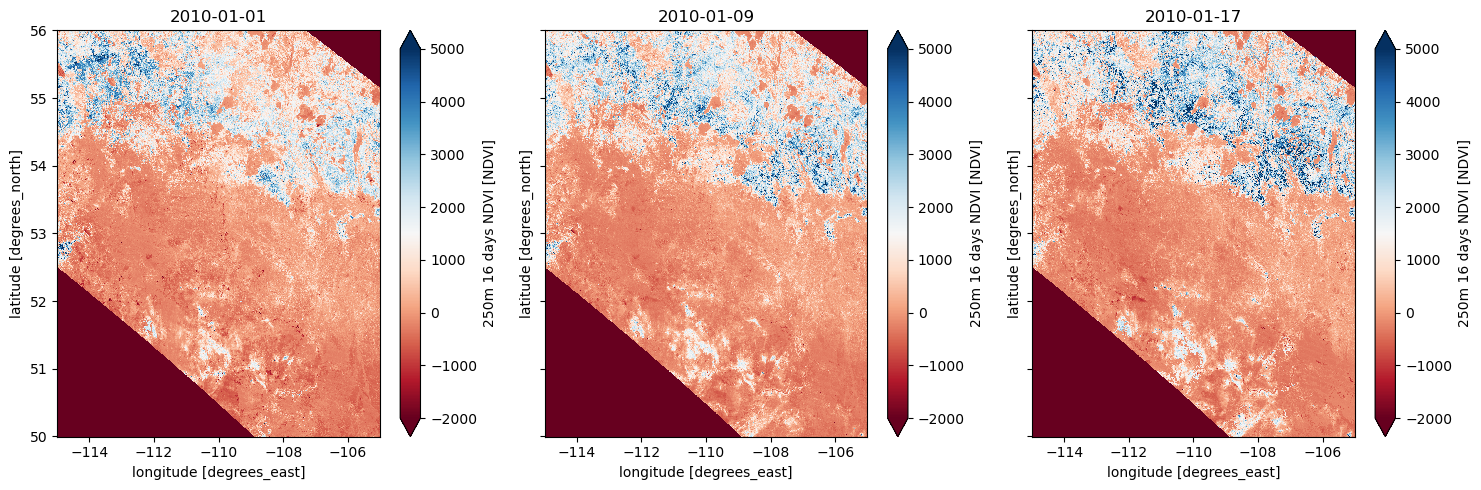

In [6]:
n = 3
fig, axes = plt.subplots(1, n, figsize=(15, 5), sharex=True, sharey=True)
axes = axes.ravel()
for i in range(n):
    ndvi_ds["250m 16 days NDVI"].isel(time=i).plot(
        cmap="RdBu", vmin=-2000, center=0, vmax=5000, ax=axes[i]
    )
    axes[i].set_title(str(ndvi_ds["time"].values[i])[:10])
plt.tight_layout()
plt.show()

In [5]:
era_ds = xr.merge([xr.open_dataset(file) for file in era5_filenames])
era_ds = (
    era_ds.rename({"longitude": "x", "latitude": "y"})
    .sel(x=xbounds, y=ybounds)
    .copy(deep=True)
)
era_ds = era_ds.resample({"time": "8D"}).mean()
era_ds

<xarray.Dataset>
Dimensions:  (x: 40, y: 24, time: 137)
Coordinates:
  * x        (x) float32 -115.0 -114.7 -114.5 -114.2 ... -105.7 -105.5 -105.2
  * y        (y) float32 55.98 55.73 55.48 55.23 ... 50.98 50.73 50.48 50.23
  * time     (time) datetime64[ns] 2010-01-01 2010-01-09 ... 2012-12-24
Data variables:
    t2m      (time, y, x) float32 251.0 250.6 250.3 250.1 ... 254.9 254.6 253.9
    tp       (time, y, x) float32 3.371e-05 2.744e-05 ... 9.46e-06 1.025e-05
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-16 04:21:44 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

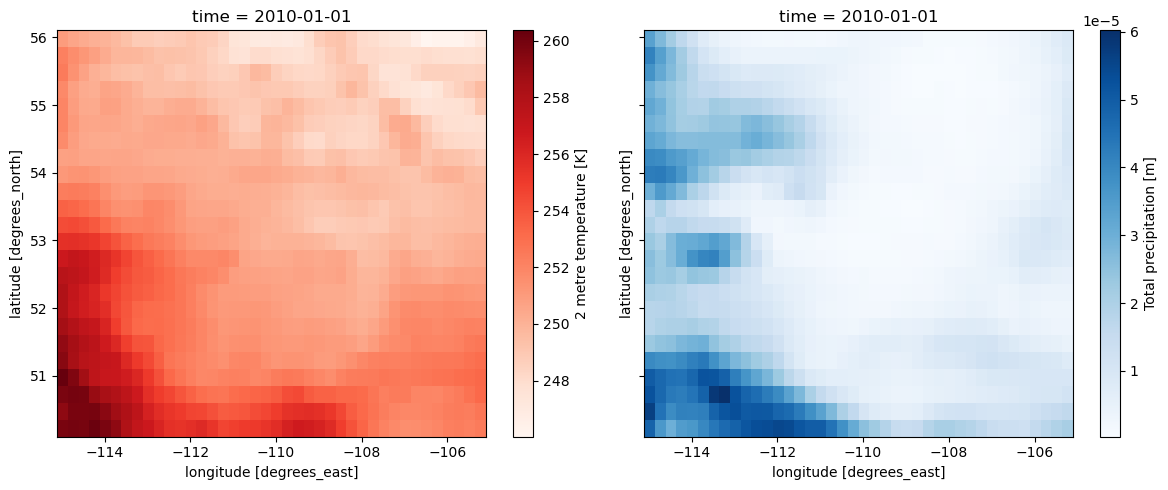

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.ravel()
era_ds["t2m"].isel(time=0).plot(cmap="Reds", ax=axes[0])
era_ds["tp"].isel(time=0).plot(cmap="Blues", ax=axes[1])
plt.tight_layout()
plt.show()

In [52]:
# era_highres = era_ds.interp(
#     coords={
#         "x": ndvi_ds["x"].values,
#         "y": ndvi_ds["y"].values,
#         "time": era_ds["time"].values,
#     },
#     method="nearest",
# ).copy(deep=True)
# era_highres

In [6]:
ds = xr.merge(
    [
        ndvi_ds.copy(deep=True),
        era_ds.reindex_like(ndvi_ds, method="nearest").copy(deep=True),
    ]
)
ds = ds.transpose("time", "x", "y")
ds

<xarray.Dataset>
Dimensions:            (x: 1422, y: 854, time: 136)
Coordinates:
  * x                  (x) float64 -115.0 -115.0 -115.0 ... -105.0 -105.0 -105.0
  * y                  (y) float64 56.0 55.99 55.98 55.98 ... 50.01 50.01 50.0
  * time               (time) datetime64[ns] 2010-01-01 ... 2012-12-16
    band               int64 1
    spatial_ref        int64 0
Data variables:
    250m 16 days NDVI  (time, x, y) float64 528.0 730.0 602.0 ... -169.0 49.0
    t2m                (time, x, y) float32 251.0 251.0 251.0 ... 258.0 258.0
    tp                 (time, x, y) float32 3.371e-05 3.371e-05 ... 7.918e-05
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             49.9999999955098
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51011003
    VERSIONID:                           61
    VERTICALTILENUMBER:                  3
    WESTBOUNDINGCOORDINATE:              -139.999999964624

In [146]:
# np.mask(ds.isel(time=0)[variables[0]])

In [7]:
variables = list(set(ds.variables) - set(ds.coords))
variables

['250m 16 days NDVI', 't2m', 'tp']

In [9]:
arr_path_out = "arrays"
norm_path_out = "normalized_arrays"

os.makedirs(arr_path_out, exist_ok=True)
os.makedirs(norm_path_out, exist_ok=True)

In [ ]:
def normalize_arr(arr):
    arr = (arr - np.nanmean(arr)) / np.nanstd(arr)
    return arr

In [156]:
for var in variables:
    if "NDVI" in var:
        var_name = "ndvi"
    else:
        var_name = var
    file_name = f"{var_name}.npy"
    path_out = os.path.join(arr_path_out, file_name)
    np.save(path_out, ds[var].values)

    arr = normalize_arr(ds[var].values)
    path_out = os.path.join(norm_path_out, file_name)
    np.save(path_out, arr)

In [116]:
ds["t2m"].isel(time=0).rio.to_raster("sample_format.tif")

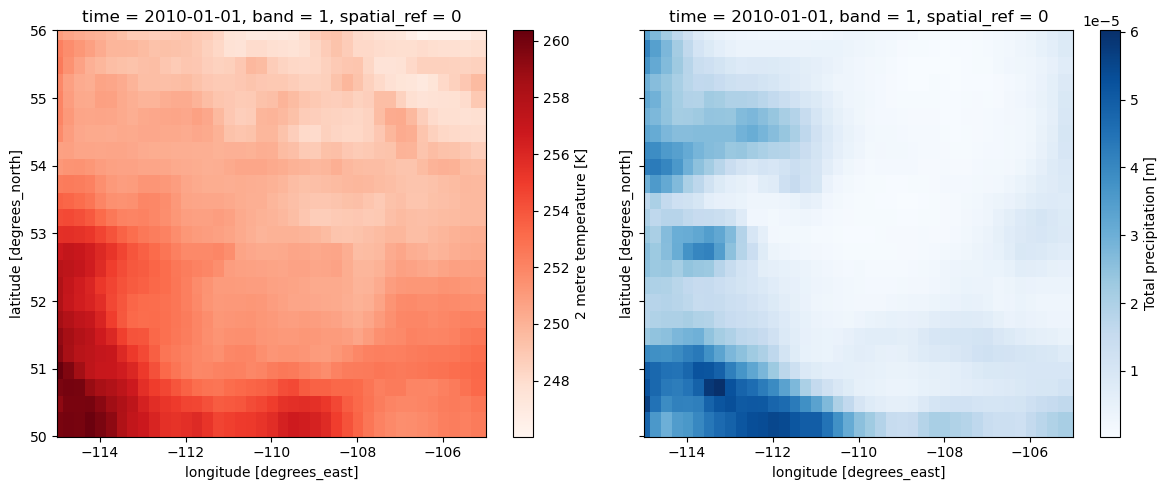

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.ravel()
ds["t2m"].isel(time=0).plot(cmap="Reds", ax=axes[0])
ds["tp"].isel(time=0).plot(cmap="Blues", ax=axes[1])
plt.tight_layout()
plt.show()

In [54]:
nodataval = ndvi_ds["250m 16 days NDVI"].attrs["_FillValue"]

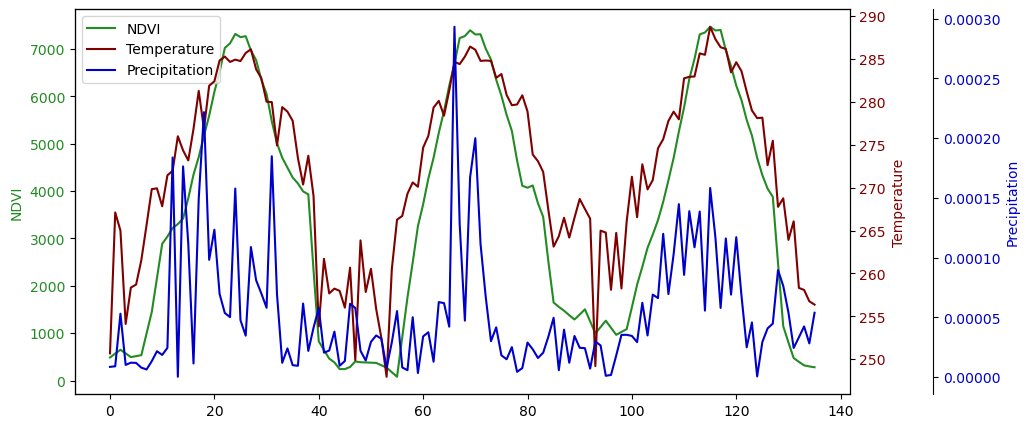

In [91]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first variable (NDVI) on the main axis
var, title, color = "250m 16 days NDVI", "NDVI", "forestgreen"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
ndvi_arr = arr.copy()
arr = np.where(ndvi_arr == nodataval, np.nan, arr)
(line1,) = ax1.plot(np.nanmean(arr, axis=1), color=color, label=title)
ax1.set_ylabel(title, color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create a twin axis for the second variable
ax2 = ax1.twinx()
var, title, color = "t2m", "Temperature", "maroon"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
arr = np.where(ndvi_arr == nodataval, np.nan, arr)
(line2,) = ax2.plot(np.nanmean(arr, axis=1), color=color, label=title)
ax2.set_ylabel(title, color=color)
ax2.tick_params(axis="y", labelcolor=color)

# Create another twin axis for the third variable, offset the spine
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # offset the third y-axis
var, title, color = "tp", "Precipitation", "mediumblue"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
arr = np.where(ndvi_arr == nodataval, np.nan, arr)
(line3,) = ax3.plot(np.nanmean(arr, axis=1), color=color, label=title)
ax3.set_ylabel(title, color=color)
ax3.tick_params(axis="y", labelcolor=color)

# Add a single legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

# Display the plot
plt.show()

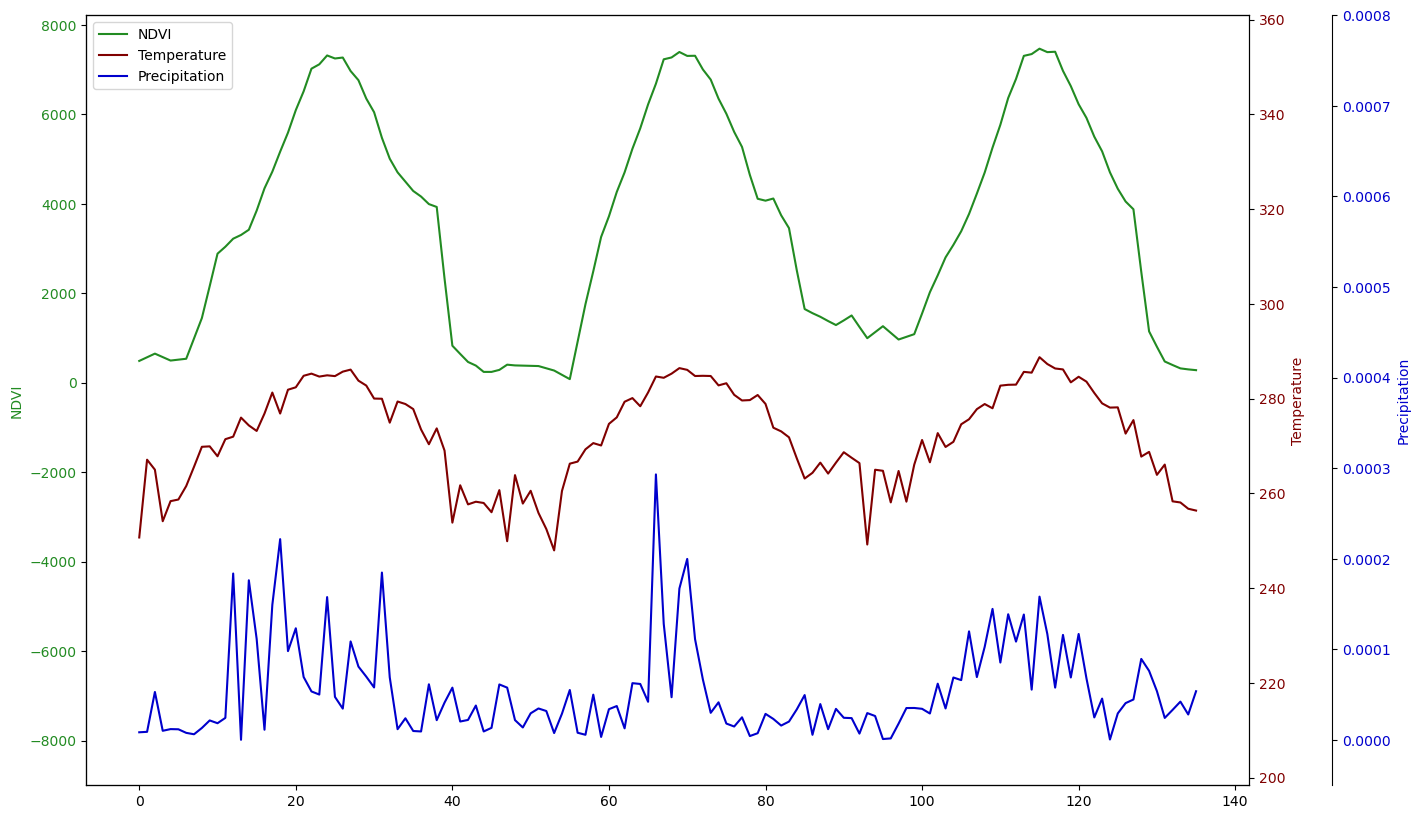

In [109]:
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot the first variable (NDVI) on the main axis
var, title, color = "250m 16 days NDVI", "NDVI", "forestgreen"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
ndvi_arr = arr.copy()
arr = np.where(ndvi_arr == nodataval, np.nan, arr)
arr = np.nanmean(arr, axis=1)
(line1,) = ax1.plot(arr, color=color, label=title)
ax1.set_ylabel(title, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax1.set_ylim(-9000, np.nanmax(arr) * 1.1)

# Create a twin axis for the second variable
ax2 = ax1.twinx()
var, title, color = "t2m", "Temperature", "maroon"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
arr = np.where(ndvi_arr == nodataval, np.nan, arr)
arr = np.nanmean(arr, axis=1)
(line2,) = ax2.plot(arr, color=color, label=title)
ax2.set_ylabel(title, color=color)
ax2.tick_params(axis="y", labelcolor=color)

ax2.set_ylim(np.nanmin(arr) * 0.8, np.nanmax(arr) * 1.25)

# Create another twin axis for the third variable, offset the spine
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # offset the third y-axis
var, title, color = "tp", "Precipitation", "mediumblue"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
arr = np.where(ndvi_arr == nodataval, np.nan, arr)
arr = np.nanmean(arr, axis=1)
(line3,) = ax3.plot(arr, color=color, label=title)
ax3.set_ylabel(title, color=color)
ax3.tick_params(axis="y", labelcolor=color)

ax3.set_ylim(-0.00005, 0.0008)

# Add a single legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

# Display the plot
plt.show()

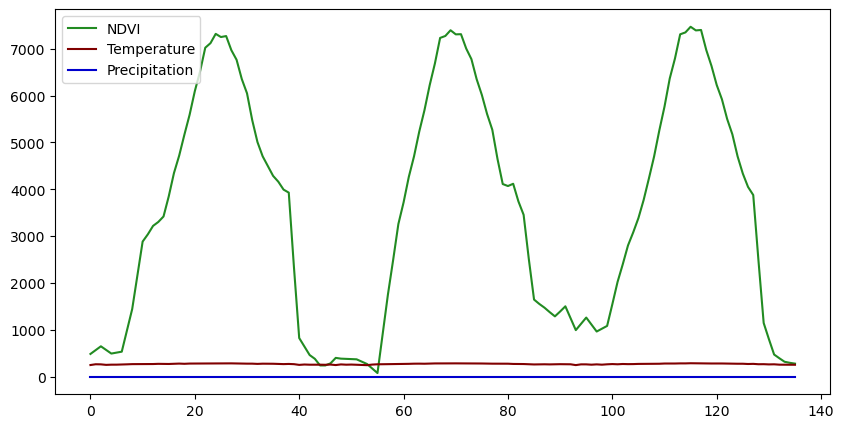

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))

arrs = []
for var, title, color in [
    ("250m 16 days NDVI", "NDVI", "forestgreen"),
    ("t2m", "Temperature", "maroon"),
    ("tp", "Precipitation", "mediumblue"),
]:
    arr = ds[var].values
    arr = arr.reshape(arr.shape[0], arr.shape[1] * arr.shape[2])
    arrs.append(arr)

    if title == "NDVI":
        ndvi_arr = arr.copy()

    # for arr in arrs:
    arr = np.where(ndvi_arr == nodataval, np.nan, arr)

    # ax.yaxis.set_ticks([])

    # Normalize
    # arr = (arr - np.nanmean(arr)) / np.nanstd(arr)
    plt.plot(
        np.nanmean(
            arr,
            axis=1,
        ).transpose(),
        color=color,
        label=title,
    )

plt.legend()
plt.show()

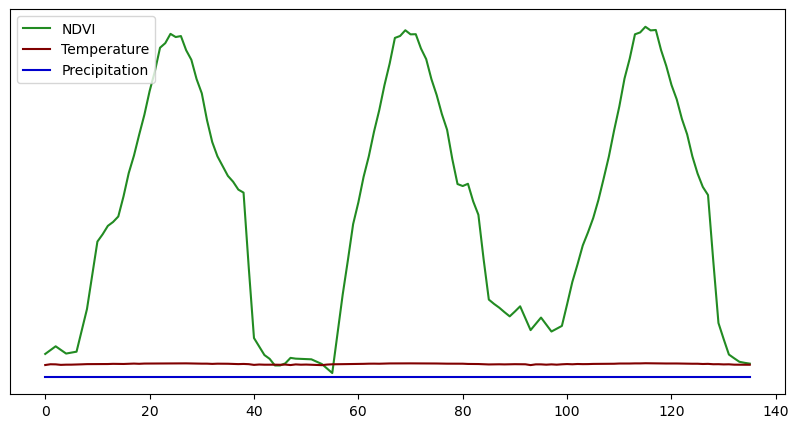

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))

arrs = []
for var, title, color in [
    ("250m 16 days NDVI", "NDVI", "forestgreen"),
    ("t2m", "Temperature", "maroon"),
    ("tp", "Precipitation", "mediumblue"),
]:
    arr = ds[var].values
    arr = arr.reshape(arr.shape[0], arr.shape[1] * arr.shape[2])
    ax.yaxis.set_ticks([])
    if title == "NDVI":
        ndvi_arr = arr.copy()
    else:
        newax = fig.add_axes(ax.get_position(), frameon=False)
        newax.yaxis.set_ticks([])
    arr = np.where(ndvi_arr == nodataval, np.nan, arr)
    # Normalize
    # arr = (arr - np.nanmean(arr)) / np.nanstd(arr)
    (vax,) = plt.plot(
        np.nanmean(
            arr,
            axis=1,
        ).transpose(),
        color=color,
        label=title,
    )
    axes.append(vax)
plt.legend(vax, ["NDVI", "Temperature", "Precipitation"])
plt.show()